## Importing and cleaning the dataset

In [1]:
#Creating a shapely line

from shapely.geometry import Point, LineString
import shapely


p1 = Point(-122.48,37.72)
p2 = Point(-122.44,37.74)
line = LineString([p1,p2])

p1.distance(p2)

0.04472135955000279

In [2]:
line.length

0.04472135955000279

In [3]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error
import contextily as ctx
import xyzservices.providers as xyz
import geopandas as gpd


sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [11, 7]

In [4]:
rentals_df = pd.read_csv('data/rentals.csv')

# Fill bathrooms Na with 0
rentals_df.bathrooms = rentals_df.bathrooms.fillna(0)

# Drop Na bedrooms
rentals_df = rentals_df.dropna(subset = ['bedrooms'])

# Change the price string to convert to float.
rentals_df.price = rentals_df.price.str.replace('$','', regex = False)
rentals_df.price = rentals_df.price.str.replace(',','', regex = False)

# Correct data types

rentals_df['property_type'] = rentals_df['property_type'].astype('category')
rentals_df['room_type'] = rentals_df['room_type'].astype('category')
rentals_df['bathrooms'] = rentals_df['bathrooms'].astype('float')
rentals_df['bedrooms'] = rentals_df['bedrooms'].astype('int')
rentals_df['minimum_nights'] = rentals_df['minimum_nights'].astype('int')
rentals_df['price'] = rentals_df['price'].astype('float')

assert rentals_df.property_type.dtype == 'category'
assert rentals_df.room_type.dtype == 'category'
assert rentals_df.bathrooms.dtype == 'float'
assert rentals_df.bedrooms.dtype == 'int'
assert rentals_df.minimum_nights.dtype == 'int'
assert rentals_df.price.dtype == 'float'

# Remove the wrong pricing
rentals_df = rentals_df[~(rentals_df.price == 0)]

In [5]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'box-cox')

rentals_df['price_normed'] = scaler.fit_transform(rentals_df['price'].values.reshape(-1,1)) 

#### Overview

In [6]:
sns.set_style('white')

In [7]:
def remove_outliers(df, multiplier = 1.5):
    """
    Removes outliers by IQR*multiplier criteria on the price_normed column
    
    Args:
    df: Dataframe with a price_normed column
    
    Returns
    Pandas DataFrame: Dataframe without outliers
    """
    
    iqr = df.price_normed.quantile(0.75) - df.price_normed.quantile(0.25)
    lower_bound = df.price_normed.quantile(0.25) - multiplier*iqr
    upper_bound = df.price_normed.quantile(0.75) + multiplier*iqr
    new_df = df[(df.price_normed > lower_bound) &
                (df.price_normed < upper_bound)]
    
    return new_df

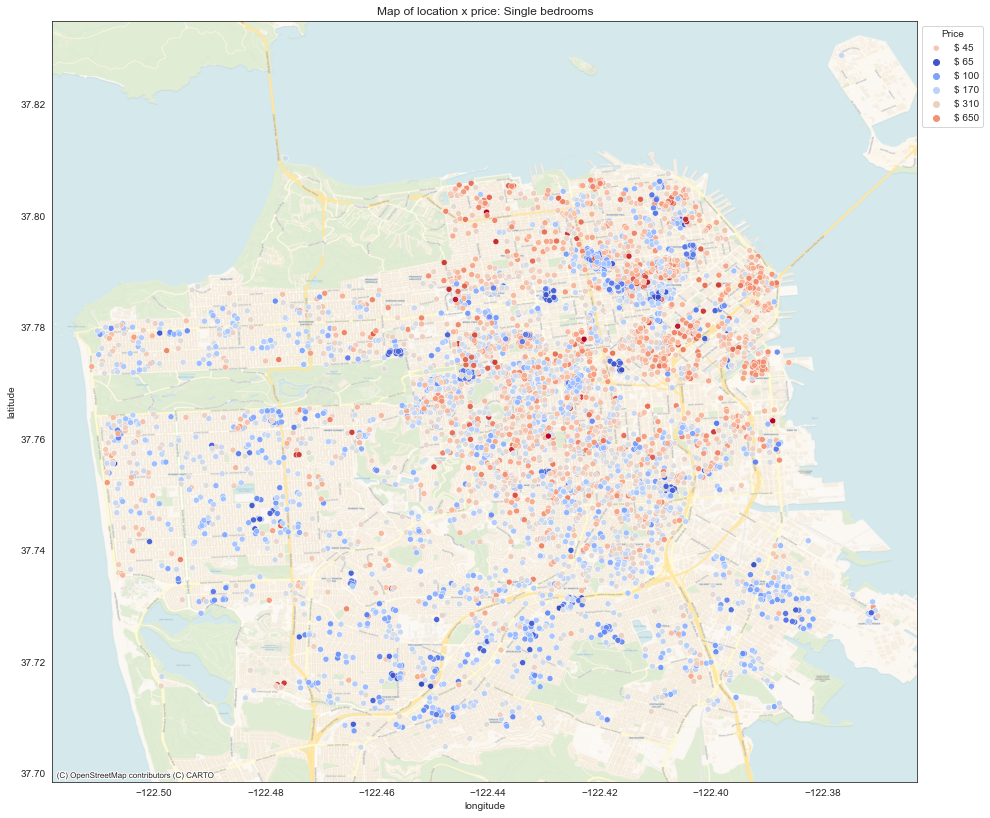

In [8]:
# Checking rental prices x locations
data_ = rentals_df[(rentals_df.bedrooms == 1)]
data_ = remove_outliers(data_)
plt.rcParams['figure.figsize'] = [22, 14]
fig, ax = plt.subplots()

sns.scatterplot(data = data_, 
                x = 'longitude', 
                y = 'latitude', 
                hue='price_normed',
                alpha = 1,
                palette = "coolwarm",
                ax = ax)
ctx.add_basemap(ax, zoom=15, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Map of location x price: Single bedrooms")
plt.legend(title='Price', labels=['$ 45', '$ 65','$ 100','$ 170', '$ 310', '$ 650'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
plt.rcParams['figure.figsize'] = [11, 7]

In [9]:
import geopandas as gpd

In [10]:
sanfrancisco_json = pd.read_json('SanFrancisco.Neighborhoods.json')

In [11]:
sanfrancisco_json.head()

type                                           features
0  FeatureCollection  {'geometry': {'geometries': [{'type': 'Polygon...
1  FeatureCollection  {'geometry': {'geometries': [{'type': 'Polygon...
2  FeatureCollection  {'geometry': {'geometries': [{'type': 'Polygon...
3  FeatureCollection  {'geometry': {'geometries': [{'type': 'Polygon...
4  FeatureCollection  {'geometry': {'geometries': [{'type': 'Polygon...

In [12]:
san_francisco_data = pd.json_normalize(sanfrancisco_json.features, max_level=0)

## Reading a GeoJson

In [13]:
san_francisco_gpd = gpd.read_file('SF Find Neighborhoods.geojson')

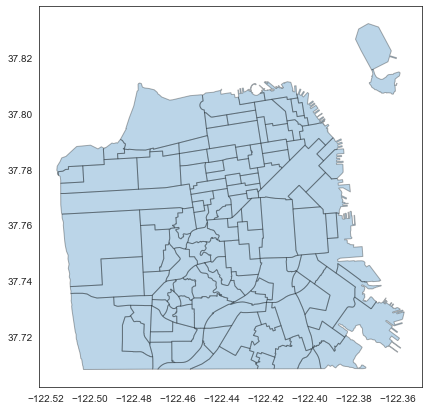

In [14]:
san_francisco_gpd.plot(alpha = 0.3, edgecolor='black')
plt.show()

In [15]:
san_francisco_gpd.head()

link                    name  \
0  http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...                Seacliff   
1                                               None             Lake Street   
2                  http://www.nps.gov/prsf/index.htm  Presidio National Park   
3                                               None        Presidio Terrace   
4  http://www.sfgate.com/neighborhoods/sf/innerri...          Inner Richmond   

                                            geometry  
0  MULTIPOLYGON (((-122.49346 37.78352, -122.4937...  
1  MULTIPOLYGON (((-122.48715 37.78379, -122.4872...  
2  MULTIPOLYGON (((-122.47758 37.81099, -122.4771...  
3  MULTIPOLYGON (((-122.47241 37.78735, -122.4710...  
4  MULTIPOLYGON (((-122.47263 37.78631, -122.4668...

In [16]:
san_francisco_gpd.geometry.head()

0    MULTIPOLYGON (((-122.49346 37.78352, -122.4937...
1    MULTIPOLYGON (((-122.48715 37.78379, -122.4872...
2    MULTIPOLYGON (((-122.47758 37.81099, -122.4771...
3    MULTIPOLYGON (((-122.47241 37.78735, -122.4710...
4    MULTIPOLYGON (((-122.47263 37.78631, -122.4668...
Name: geometry, dtype: geometry

## Calculating area and distance

Get an area specific EPSG

- https://epsg.io/
- Web Mercator projection (EPSG:3857)
- Geodesic (EPSG: 4326)
- San Francisco (EPSG: 7131)

In [17]:
san_francisco_gpd.geometry.to_crs(epsg = 7131).area

0      4.612027e+05
1      3.838932e+05
2      6.141365e+06
3      3.289324e+05
4      2.267118e+06
           ...     
112    2.845332e+05
113    3.438190e+05
114    7.591149e+05
115    4.331868e+05
116    5.400344e+05
Length: 117, dtype: float64

## Making a geodataframe from a pandas dataframe

     id  latitude  longitude property_type        room_type  bathrooms  \
0   958  37.76931 -122.43386     Apartment  Entire home/apt        1.0   
1  3850  37.75402 -122.45805         House     Private room        1.0   
2  5858  37.74511 -122.42102     Apartment  Entire home/apt        1.0   
3  7918  37.76669 -122.45250     Apartment     Private room        4.0   
4  8142  37.76487 -122.45183     Apartment     Private room        4.0   

   bedrooms  minimum_nights  price  price_normed                     geometry  
0         1               1  170.0      0.159489  POINT (-122.43386 37.76931)  
1         1               1   99.0     -0.646562  POINT (-122.45805 37.75402)  
2         2              30  235.0      0.599003  POINT (-122.42102 37.74511)  
3         1              32   65.0     -1.342276  POINT (-122.45250 37.76669)  
4         1              32   65.0     -1.342276  POINT (-122.45183 37.76487)  


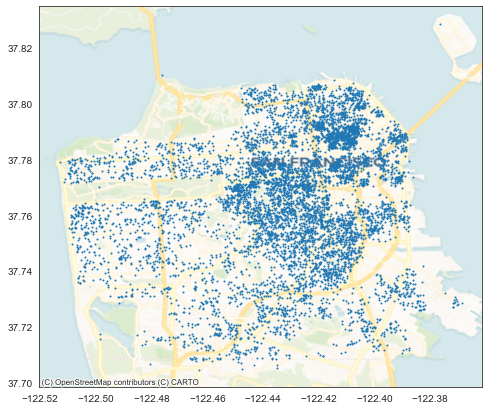

In [18]:
# Convert it to a GeoDataFrame
hotels = gpd.GeoDataFrame(rentals_df, geometry=gpd.points_from_xy(rentals_df.longitude, rentals_df.latitude))
hotels.set_crs(epsg=4326, inplace=True)
print(hotels.head())

# Make a plot of the restaurants
ax = hotels.plot(markersize=1)

ctx.add_basemap(ax, zoom=12, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
plt.show()

In [25]:
san_francisco_gpd

link  \
0    http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...   
1                                                 None   
2                    http://www.nps.gov/prsf/index.htm   
3                                                 None   
4    http://www.sfgate.com/neighborhoods/sf/innerri...   
..                                                 ...   
112  http://en.wikipedia.org/wiki/Corona_Heights,_S...   
113        http://en.wikipedia.org/wiki/Haight-Ashbury   
114  http://en.wikipedia.org/wiki/Eureka_Valley,_Sa...   
115  http://en.wikipedia.org/wiki/St._Francis_Wood,...   
116  http://en.wikipedia.org/wiki/Neighborhoods_in_...   

                       name                                           geometry  
0                  Seacliff  MULTIPOLYGON (((-122.49346 37.78352, -122.4937...  
1               Lake Street  MULTIPOLYGON (((-122.48715 37.78379, -122.4872...  
2    Presidio National Park  MULTIPOLYGON (((-122.47758 37.81099, -122.4771...  
3          Presidio Terrace  MULTIPOLYGON (((-122.47241 37.78735, -122.4710...  
4            Inner Richmond  MULTIPOLYGON (((-122.47263 37.78631, -122.4668...  
..                      ...                                                ...  
112          Corona Heights  MULTIPOLYGON (((-122.43519 37.76267, -122.4353...  
113         Ashbury Heights  MULTIPOLYGON (((-122.45196 37.76148, -122.4521...  
114           Eureka Valley  MULTIPOLYGON (((-122.43734 37.76235, -122.4370...  
115        St. Francis Wood  MULTIPOLYGON (((-122.47157 37.73471, -122.4683...  
116         Sherwood Forest  MULTIPOLYGON (((-122.45890 37.74054, -122.4587...  

[117 rows x 3 columns]

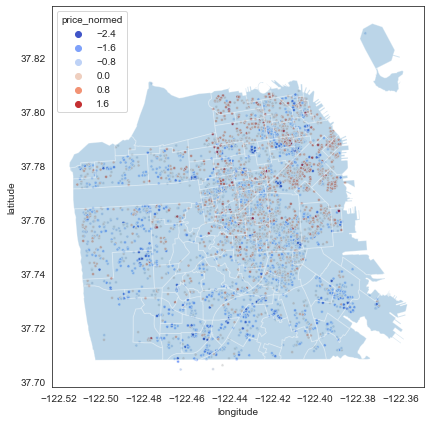

In [24]:
ax = sns.scatterplot(data = data_, 
                x = 'longitude', 
                y = 'latitude', 
                hue='price_normed',
                     marker = '.',
                alpha = 1,
                palette = "coolwarm")
san_francisco_gpd.plot(alpha = 0.3, ax = ax)
plt.show()

In [34]:
rentals_df.head()

id  latitude  longitude property_type        room_type  bathrooms  \
0   958  37.76931 -122.43386     Apartment  Entire home/apt        1.0   
1  3850  37.75402 -122.45805         House     Private room        1.0   
2  5858  37.74511 -122.42102     Apartment  Entire home/apt        1.0   
3  7918  37.76669 -122.45250     Apartment     Private room        4.0   
4  8142  37.76487 -122.45183     Apartment     Private room        4.0   

   bedrooms  minimum_nights  price  price_normed                     geometry  
0         1               1  170.0      0.159489  POINT (-122.43386 37.76931)  
1         1               1   99.0     -0.646562  POINT (-122.45805 37.75402)  
2         2              30  235.0      0.599003  POINT (-122.42102 37.74511)  
3         1              32   65.0     -1.342276  POINT (-122.45250 37.76669)  
4         1              32   65.0     -1.342276  POINT (-122.45183 37.76487)

In [35]:
import folium


ax = folium.Map()
# san_francisco_gpd.explore()

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.latitude, point.longitude],
                        radius=2,
                        weight=5).add_to(ax)

rentals_df[(rentals_df.property_type == 'Apartment') & (rentals_df.minimum_nights == 1)].apply(plotDot, axis = 1)
ax.fit_bounds(ax.get_bounds())
ax

In [ ]:
san_francisco_gpd.explore(column = '')

The geometry column consists on a shapely object.

It can be a point, linestring, polygon, multipolygon, etc.

In [30]:
san_francisco_gpd

link  \
0    http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...   
1                                                 None   
2                    http://www.nps.gov/prsf/index.htm   
3                                                 None   
4    http://www.sfgate.com/neighborhoods/sf/innerri...   
..                                                 ...   
112  http://en.wikipedia.org/wiki/Corona_Heights,_S...   
113        http://en.wikipedia.org/wiki/Haight-Ashbury   
114  http://en.wikipedia.org/wiki/Eureka_Valley,_Sa...   
115  http://en.wikipedia.org/wiki/St._Francis_Wood,...   
116  http://en.wikipedia.org/wiki/Neighborhoods_in_...   

                       name                                           geometry  
0                  Seacliff  MULTIPOLYGON (((-122.49346 37.78352, -122.4937...  
1               Lake Street  MULTIPOLYGON (((-122.48715 37.78379, -122.4872...  
2    Presidio National Park  MULTIPOLYGON (((-122.47758 37.81099, -122.4771...  
3          Presidio Terrace  MULTIPOLYGON (((-122.47241 37.78735, -122.4710...  
4            Inner Richmond  MULTIPOLYGON (((-122.47263 37.78631, -122.4668...  
..                      ...                                                ...  
112          Corona Heights  MULTIPOLYGON (((-122.43519 37.76267, -122.4353...  
113         Ashbury Heights  MULTIPOLYGON (((-122.45196 37.76148, -122.4521...  
114           Eureka Valley  MULTIPOLYGON (((-122.43734 37.76235, -122.4370...  
115        St. Francis Wood  MULTIPOLYGON (((-122.47157 37.73471, -122.4683...  
116         Sherwood Forest  MULTIPOLYGON (((-122.45890 37.74054, -122.4587...  

[117 rows x 3 columns]

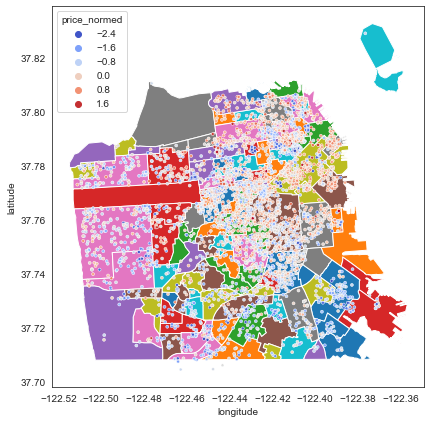

In [31]:
fig, ax = plt.subplots()
san_francisco_gpd.plot(column = 'name', ax = ax)
sns.scatterplot(data = data_, 
                x = 'longitude', 
                y = 'latitude', 
                hue='price_normed',
                marker = '.',
                alpha = 1,
                palette = "coolwarm",
                ax = ax)
plt.show()

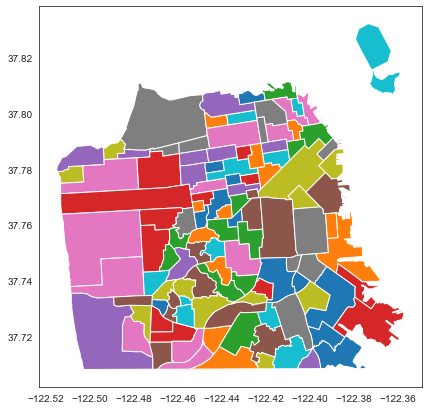

In [32]:
fig, ax = plt.subplots()
san_francisco_gpd.plot(column = 'name', ax = ax, markersize = 100)
plt.show()

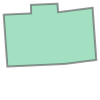

In [215]:
san_francisco_gpd.geometry[4]

In [216]:
san_francisco_gpd.loc[4]

link        http://www.sfgate.com/neighborhoods/sf/innerri...
name                                           Inner Richmond
geometry    MULTIPOLYGON (((-122.47262578999994 37.7863148...
Name: 4, dtype: object

In [217]:
# "Contains" method
# san_francisco_gpd.geometry[0] = Seacliff

seacliff_hotels = hotels[san_francisco_gpd.geometry[0].contains(hotels.geometry)]

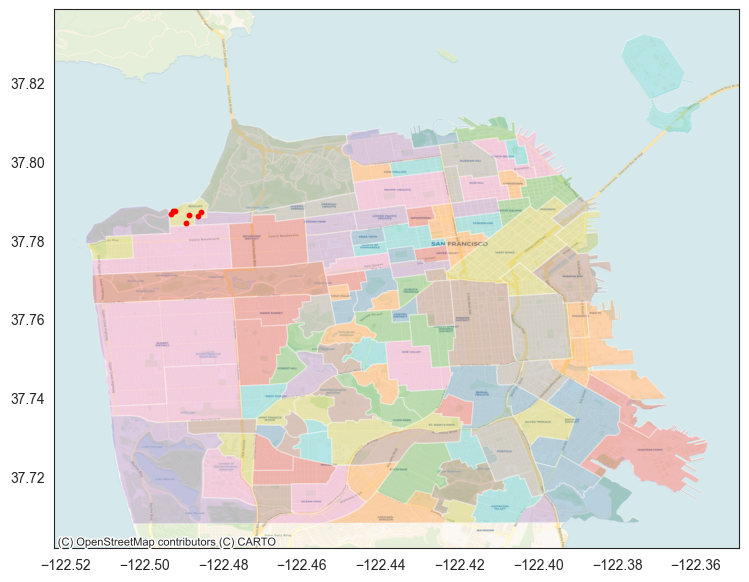

In [218]:
fig, ax = plt.subplots()

san_francisco_gpd.plot(column = 'name', ax = ax, alpha = 0.3)
seacliff_hotels.plot(markersize=10, ax = ax, color = 'r')
ctx.add_basemap(ax, zoom=14, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
plt.show()

In [219]:
# "within" method searches on the geometry column
# san_francisco_gpd.geometry[4] = inner richmond

inner_richmond_hotels = hotels[hotels.within(san_francisco_gpd.geometry[4])]

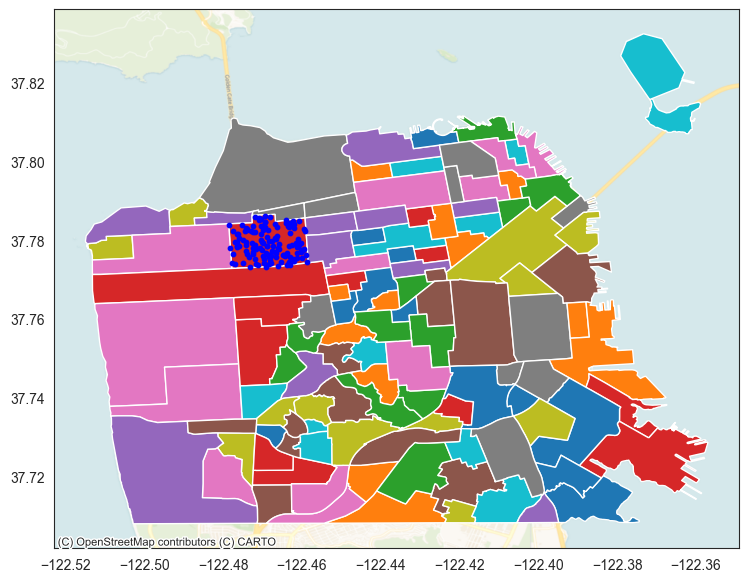

In [220]:
fig, ax = plt.subplots()

san_francisco_gpd.plot(column = 'name', ax = ax)
inner_richmond_hotels.plot(markersize=10, ax = ax, color = 'b')
ctx.add_basemap(ax, zoom=13, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
plt.show()

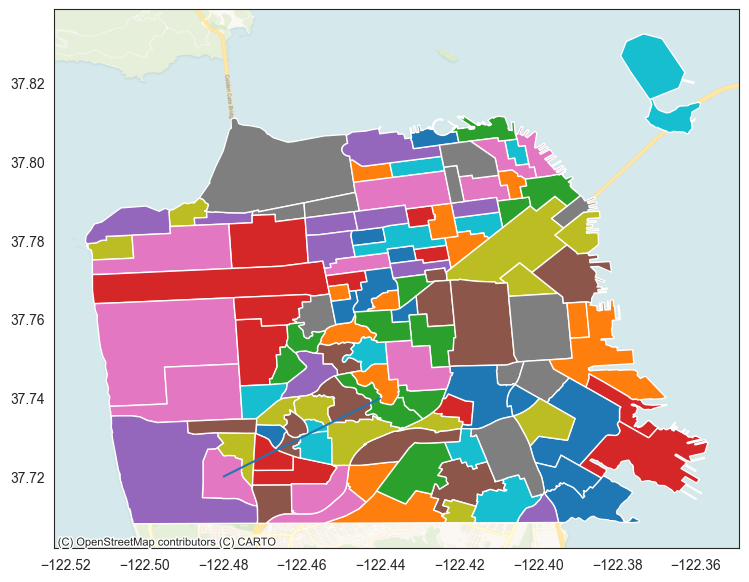

In [221]:
#Plotting a shapely line

fig, ax = plt.subplots()
san_francisco_gpd.plot(column = 'name', ax = ax)
line_gpd = gpd.GeoSeries(line)
line_gpd.plot(ax = ax)
ctx.add_basemap(ax, zoom=13, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
plt.show()

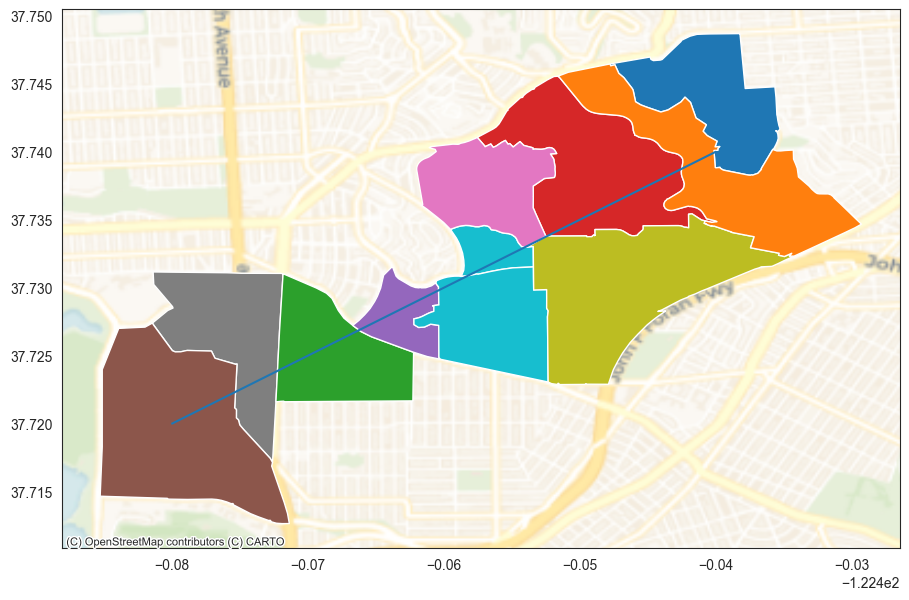

In [222]:
fig, ax = plt.subplots()
intersected_districts = san_francisco_gpd[line.intersects(san_francisco_gpd.geometry)]
intersected_districts.plot(column = 'name', ax = ax)
gpd.GeoSeries(line).plot(ax = ax)
ctx.add_basemap(ax, zoom=13, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
plt.show()

In [229]:
hotels.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

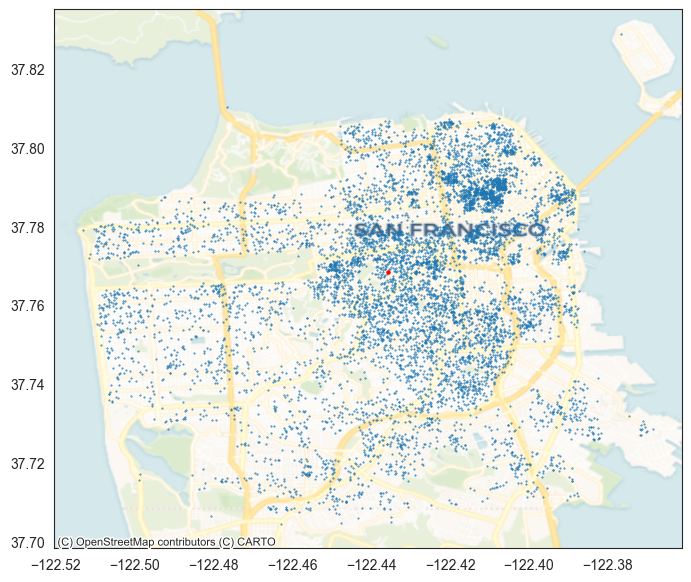

In [236]:
ax = hotels.plot(markersize=0.2)
gpd.GeoSeries(hotels.loc[4000].geometry).plot(color = 'r', markersize = 5, ax = ax)
ctx.add_basemap(ax, zoom=12, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)
plt.show()

In [278]:
hotels.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [329]:
# Get hotels close to hotel 4000 in meters

dist_h4000 = hotels.to_crs(epsg = 7131).distance(hotels.to_crs(epsg = 7131).loc[4000].geometry)

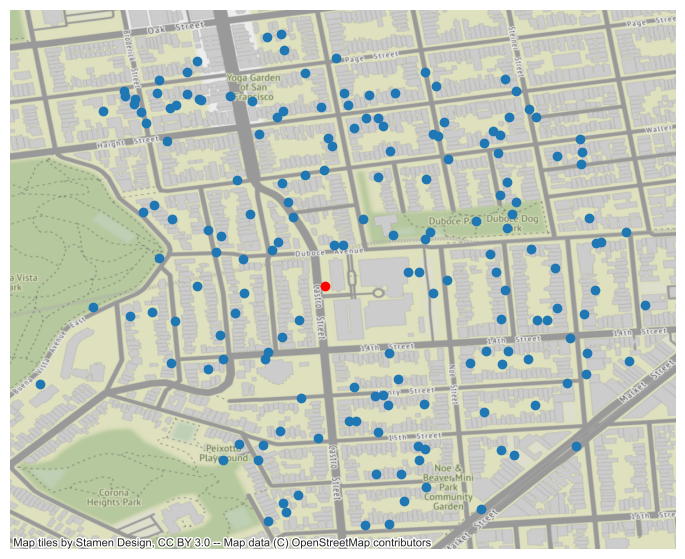

In [330]:
# Filter the hotels within 500m

close_hotels = hotels[dist_h4000 < 500].drop(4000)

# Make a plot of the close-by restaurants
ax = close_hotels.plot()
gpd.GeoSeries(hotels.loc[4000].geometry).plot(ax=ax, color='red')
contextily.add_basemap(ax, zoom=17, crs='EPSG:4326')
ax.set_axis_off()
plt.show()

## Spacial join

In [285]:
san_francisco_gpd.head()

link                    name  \
0  http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...                Seacliff   
1                                               None             Lake Street   
2                  http://www.nps.gov/prsf/index.htm  Presidio National Park   
3                                               None        Presidio Terrace   
4  http://www.sfgate.com/neighborhoods/sf/innerri...          Inner Richmond   

                                            geometry  
0  MULTIPOLYGON (((-122.49346 37.78352, -122.4937...  
1  MULTIPOLYGON (((-122.48715 37.78379, -122.4872...  
2  MULTIPOLYGON (((-122.47758 37.81099, -122.4771...  
3  MULTIPOLYGON (((-122.47241 37.78735, -122.4710...  
4  MULTIPOLYGON (((-122.47263 37.78631, -122.4668...

In [286]:
hotels_joined = gpd.sjoin(hotels, san_francisco_gpd[['name', 'geometry']], predicate = 'within')
hotels_joined = hotels_joined.rename(columns={'name':'district'})

In [287]:
hotels_joined.head()

id  latitude  longitude property_type        room_type  bathrooms  \
0       958  37.76931 -122.43386     Apartment  Entire home/apt        1.0   
75    60365  37.76966 -122.43496         House  Entire home/apt        2.0   
123  121065  37.77083 -122.43109     Apartment  Entire home/apt        1.0   
141  148559  37.76787 -122.43172     Apartment  Entire home/apt        1.0   
179  225933  37.76840 -122.43086     Apartment     Private room        1.0   

     bedrooms  minimum_nights  price  price_normed  \
0           1               1  170.0      0.159489   
75          3               4  475.0      1.454559   
123         1              30  200.0      0.383937   
141         2               5  275.0      0.801536   
179         1               3   99.0     -0.646562   

                        geometry  index_right         district  
0    POINT (-122.43386 37.76931)           27  Duboce Triangle  
75   POINT (-122.43496 37.76966)           27  Duboce Triangle  
123  POINT (-122.43109 37.77083)           27  Duboce Triangle  
141  POINT (-122.43172 37.76787)           27  Duboce Triangle  
179  POINT (-122.43086 37.76840)           27  Duboce Triangle

In [288]:
hotels_by_district = hotels_joined.groupby('district').size()
hotels_by_district = hotels_by_district.to_frame(name='n_hotels')

In [289]:
hotels_by_district

n_hotels
district                          
Alamo Square                    78
Anza Vista                      30
Aquatic Park / Ft. Mason        31
Ashbury Heights                 49
Balboa Terrace                   2
...                            ...
Visitacion Valley               26
West Portal                     20
Western Addition               116
Westwood Highlands               5
Westwood Park                   25

[114 rows x 1 columns]

In [290]:
san_francisco_gpd

link  \
0    http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...   
1                                                 None   
2                    http://www.nps.gov/prsf/index.htm   
3                                                 None   
4    http://www.sfgate.com/neighborhoods/sf/innerri...   
..                                                 ...   
112  http://en.wikipedia.org/wiki/Corona_Heights,_S...   
113        http://en.wikipedia.org/wiki/Haight-Ashbury   
114  http://en.wikipedia.org/wiki/Eureka_Valley,_Sa...   
115  http://en.wikipedia.org/wiki/St._Francis_Wood,...   
116  http://en.wikipedia.org/wiki/Neighborhoods_in_...   

                       name                                           geometry  
0                  Seacliff  MULTIPOLYGON (((-122.49346 37.78352, -122.4937...  
1               Lake Street  MULTIPOLYGON (((-122.48715 37.78379, -122.4872...  
2    Presidio National Park  MULTIPOLYGON (((-122.47758 37.81099, -122.4771...  
3          Presidio Terrace  MULTIPOLYGON (((-122.47241 37.78735, -122.4710...  
4            Inner Richmond  MULTIPOLYGON (((-122.47263 37.78631, -122.4668...  
..                      ...                                                ...  
112          Corona Heights  MULTIPOLYGON (((-122.43519 37.76267, -122.4353...  
113         Ashbury Heights  MULTIPOLYGON (((-122.45196 37.76148, -122.4521...  
114           Eureka Valley  MULTIPOLYGON (((-122.43734 37.76235, -122.4370...  
115        St. Francis Wood  MULTIPOLYGON (((-122.47157 37.73471, -122.4683...  
116         Sherwood Forest  MULTIPOLYGON (((-122.45890 37.74054, -122.4587...  

[117 rows x 3 columns]

In [331]:
san_francisco_gpd = pd.merge(san_francisco_gpd, hotels_by_district, left_on='name', right_on='district')

In [332]:
san_francisco_gpd['density_km'] = san_francisco_gpd.n_hotels/(san_francisco_gpd.to_crs(epsg = 7131).geometry.area/1000000)

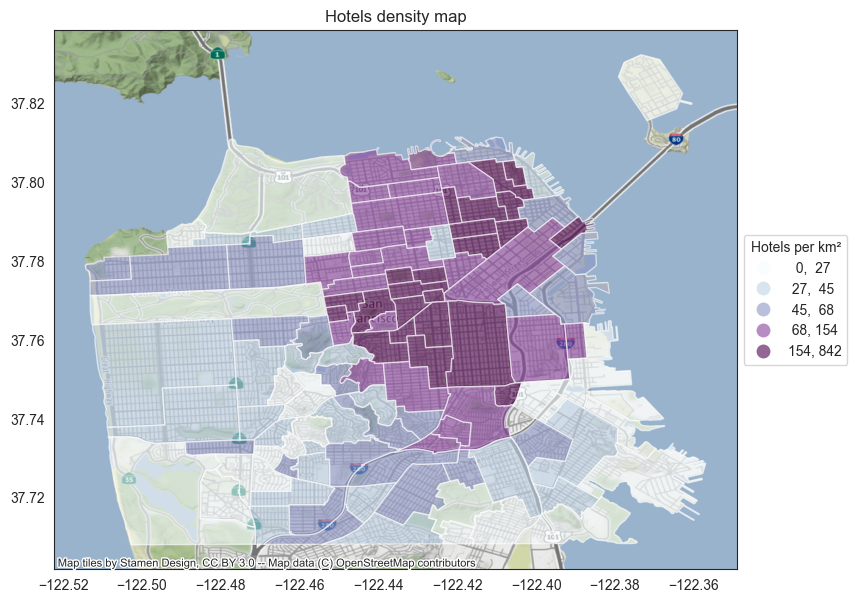

In [333]:
ax = san_francisco_gpd.plot(column='density_km', legend = True, scheme='QUANTILES', 
                            cmap='BuPu', alpha = 0.6,
                            legend_kwds={'loc': 'center left', 
                                         'bbox_to_anchor':(1,0.5),  
                                         'fmt':"{:.0f}",
                                         'title':'Hotels per km²'})
contextily.add_basemap(ax, zoom=13, crs='EPSG:4326')
plt.title("Hotels density map")
plt.show()